# Goal
- The yelp database contains the following information on businesses:
  - Business information such as location, reviews, number of reviews
  - Distinct reviews for each business from individual users
  - Users each with their own metadata
  - Tips containing user's feedback for other customers regarding businesses
  - Checkins indicating the number of times a user has checked into a business
  - Photos containing a caption and a label; many for individual businesses
  
- We can use this information to explore if any of these characteristics are
  associated with high risk businesses, as indicated by a lower yelp review.
  After exploring the data, we can create a simple model that attempts to
  identify the internal risk associated with a business.
  
## Conclusion
- We gather the following data points from the raw data:
  - Business review
  - Number of reviews
  - Time/duration since first review as a proxy for length of time business has been open
  - Variability of reviews using standard deviation
  - Total number of checkins, tips, and photos
- We then look at a correlation coefficient matrix and observe that higher risk businesses
  as indicated by a low review scores show a non-trivial correlation to variable customer
  experiences. Other features also show intra-correlation.
- Lastly we build a simple supervised binary classification model with random forests to
  predict the riskiness of a business given a set of features with 69% generalization error.
  Next steps are present in the analysis below at the very end since this is just an initial
  value and more work is needed to be rigorous.

## ----------------------------------------------------------------------------------------------------------------------------------

# Imports and Setup

In [9]:
import pymongo
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [10]:
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client.public

## Utility functions

In [11]:
def get_data(cursor):
    # Use list comprehension to obtain list of dictionary for cursor
    return [val for val in cursor]

def get_checkins(cursor):
    # Iterate over values and count the number of 'date' entries indicating
    # the total number of checkins a business has received
    data = []
    for val in cursor:
        if val['date'] is None or val['date'] == '':
            checkins = 0
        else:
            checkins = len(val['date'].split(','))
        data.append([val['business_id'], checkins])
    return data

# Data Gathering

## Review and review count for business
#### First grab the review and the number of reviews for all businesses that _are open_. We suspect that very risky businesses and very safe businesses may have the highest number of reviews, in general. We use the 'review' as a proxy for the risk associated with insuring a business. We assign any business with a review greater than 3 as LOW risk, or 0. Any business with 3 or lower is HIGH risk. We include 3 because it will make the model more conservative in general.

In [12]:
cursor = db.business.find({'is_open': 1}, {'business_id': 1, 'stars':1, 'review_count': 1, '_id': 0})
data = get_data(cursor)
result = pd.DataFrame(data)
# Create a risk rating of 0 for stars greater than 3 else put a 1. We will map these to HIGH and LOW risk.
result['risk_rating'] = [0 if val > 3 else 1 for val in result['stars']]
result[:2]

,business_id,stars,review_count,risk_rating
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,128,1
1,xvX2CttrVhyG2z1dFg_0xw,5.0,3,0


In [13]:
print('Current number of systems in resultant dataset: {}'.format(len(result)))

Current number of systems in resultant dataset: 158525


## Duration since first review
#### We can use the review information to retrieve the duration since first review as a proxy for the length of time the business has been open. Businesses that have been open longer may be considered less risky. We calculate the duration the business has been open in days and store that in our dataset since we will use that to normalize the cumulative fields.

In [14]:
cursor = db.review.aggregate([ {"$group" : {"_id":"$business_id", "first_review":{"$min":"$date"}}} ])
data = get_data(cursor)
data = pd.DataFrame(data).rename(columns={'_id':'business_id'})

# Calculate the duration since first review
analysis_date = pd.Timestamp(datetime.date(2020, 3, 12))
data['first_review'] = [pd.to_datetime(val) for val in data['first_review']]
data['duration'] = [(analysis_date - val).days for val in data['first_review']]

In [15]:
result = pd.merge(result, data, on='business_id') # Every business should have a review
# Normalize review count to the duration
result['review_count'] = result['review_count']/result['duration']
result[:2]

,business_id,stars,review_count,risk_rating,first_review,duration
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,0.032177,1,2009-04-20 00:58:34,3978
1,xvX2CttrVhyG2z1dFg_0xw,5.0,0.001142,0,2013-01-01 18:06:38,2626


In [16]:
print('Current number of systems in resultant dataset: {}'.format(len(result)))

Current number of systems in resultant dataset: 158522


## Variability of reviews
#### We compute the standard deviation of the reviews as a measure of the volatility of an individual user experience at a business. The more volatile the experience is for a customer, the riskier the business may be to insure. We also note that a variability of 0 should be reflected as a null since this will happen where a business has only one review.

In [17]:
cursor = db.review.aggregate([ {"$group" : {"_id":"$business_id", "std_dev":{"$stdDevSamp":"$stars"}}} ])
data = get_data(cursor)
data = pd.DataFrame(data).rename(columns={'_id':'business_id'})

In [18]:
result = pd.merge(result, data, on='business_id') # Every business should have a review
result[:2]

,business_id,stars,review_count,risk_rating,first_review,duration,std_dev
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,0.032177,1,2009-04-20 00:58:34,3978,1.297361
1,xvX2CttrVhyG2z1dFg_0xw,5.0,0.001142,0,2013-01-01 18:06:38,2626,0.000000


In [19]:
print('Current number of systems in resultant dataset: {}'.format(len(result)))

Current number of systems in resultant dataset: 158522


## Total Number of checkins
#### The total number of checkins will give us a measure of relative popularity. We would expect more popular and therefore generally less risky businesses to have more checkins on a consistent basis.

In [20]:
cursor = db.checkin.find({}, {'business_id': 1, 'date': 1, '_id': 0})
data = get_checkins(cursor)
data = pd.DataFrame(data, columns=['business_id', 'checkins'])

In [21]:
result = pd.merge(result, data, on='business_id', how='left') # Not every business may have a checkin
result['checkins'] = result['checkins']/result['duration']
result[:2]

,business_id,stars,review_count,risk_rating,first_review,duration,std_dev,checkins
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,0.032177,1,2009-04-20 00:58:34,3978,1.297361,0.114379
1,xvX2CttrVhyG2z1dFg_0xw,5.0,0.001142,0,2013-01-01 18:06:38,2626,0.000000,0.004189


In [22]:
print('Current number of systems in resultant dataset: {}'.format(len(result)))

Current number of systems in resultant dataset: 158522


## Total number of tips
#### The total number of tips should also indicate another measure of relative popularity and strength for a business.

In [23]:
cursor = db.tip.aggregate([ {"$group" : {"_id":"$business_id", "tips":{"$sum":1}}} ])
data = get_data(cursor)
data = pd.DataFrame(data).rename(columns={'_id':'business_id'})

In [24]:
result = pd.merge(result, data, on='business_id', how='left') # Not every business will have a tip
result['tips'] = result['tips']/result['duration']
result[:2]

,business_id,stars,review_count,risk_rating,first_review,duration,std_dev,checkins,tips
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,0.032177,1,2009-04-20 00:58:34,3978,1.297361,0.114379,0.00553
1,xvX2CttrVhyG2z1dFg_0xw,5.0,0.001142,0,2013-01-01 18:06:38,2626,0.000000,0.004189,NaN


In [25]:
print('Current number of systems in resultant dataset: {}'.format(len(result)))

Current number of systems in resultant dataset: 158522


## Total number of photos
#### The total number of photos may be associated with either very risky or very safe businesses.

In [26]:
cursor = db.photo.aggregate([ {"$group" : {"_id":"$business_id", "photos":{"$sum":1}}} ])
data = get_data(cursor)
data = pd.DataFrame(data).rename(columns={'_id':'business_id'})

In [27]:
result = pd.merge(result, data, on='business_id', how='left') # Not every business will have a photo
result['photos'] = result['photos']/result['duration']
result[:2]

,business_id,stars,review_count,risk_rating,first_review,duration,std_dev,checkins,tips,photos
0,QXAEGFB4oINsVuTFxEYKFQ,2.5,0.032177,1,2009-04-20 00:58:34,3978,1.297361,0.114379,0.00553,0.000754
1,xvX2CttrVhyG2z1dFg_0xw,5.0,0.001142,0,2013-01-01 18:06:38,2626,0.000000,0.004189,NaN,NaN


In [28]:
print('Current number of systems in resultant dataset: {}'.format(len(result)))

Current number of systems in resultant dataset: 158522


# Analysis

In [29]:
result = result.fillna(0)
analysis_data = result[['risk_rating' ,'review_count', 'std_dev', 'checkins', 'tips', 'photos']]
analysis_data[:5]

,risk_rating,review_count,std_dev,checkins,tips,photos
0,1,0.032177,1.297361,0.114379,0.005530,0.000754
1,0,0.001142,0.000000,0.004189,0.000000,0.000000
2,0,0.001905,2.000000,0.000000,0.000000,0.000000
3,1,0.001343,1.527525,0.001343,0.000448,0.000000
4,0,0.001298,2.309401,0.004758,0.000000,0.000000


### Let's look at the correlation matrix between every individual category against each other. The output will be the correlation coefficient and is a symmetric matrix so values below the diagonal can be ignored.

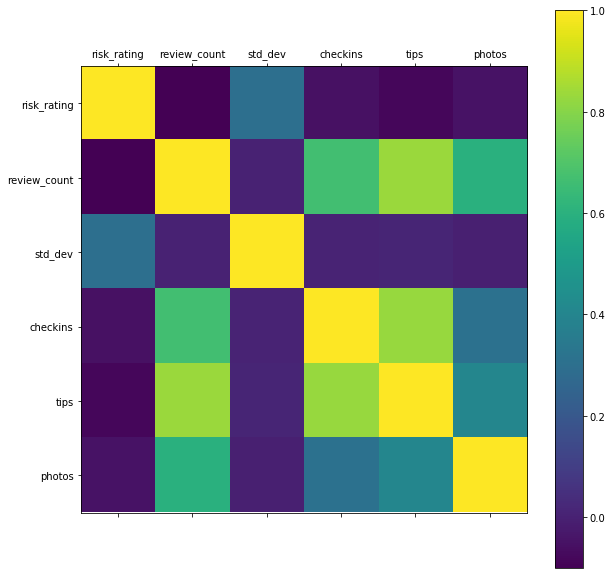

In [49]:
plt.figure(figsize=(10, 10))
plt.matshow(analysis_data.corr(), fignum=1)
plt.xticks(range(len(analysis_data.columns)), analysis_data.columns)
plt.yticks(range(len(analysis_data.columns)), analysis_data.columns)
plt.colorbar()

The results above seem to show that only one feature, namely the variability of a customer's experience is indicative of somewhat of a _linear_ correlation. Perhaps this indicates that a higher variability in customer experience also increases the internal risk of insuring a business? It also seems that the review count is strong correlated with the number of check ins, the number of tips and the number of photos; that seems to make sense even for high and low risk businesses.

## Building a simple supervised model
#### We can attempt to build a supervised model with our training that will output the risk of a business given the above feature set. A score of 1 is HIGH risk and a score of 0 is LOW risk. This amounts to a classification task. We use a random forest classifier since we have features that are non-trivially correlated with each other. The random forest classifier is a class of decision tree models where we can think of the result as a series of yes/no questions asked about our data eventually leading to a predicted class.

In [50]:
labels = analysis_data['risk_rating']
features = analysis_data[['review_count', 'std_dev', 'checkins', 'tips', 'photos']]

In [51]:
# Train on 80% data, Test on 20% data
coefficient = 0.8
index = int(len(labels)*coefficient)
train_labels, test_labels = labels[:index], labels[index+1:]
train_features, test_features = features[:index], features[index+1:]

fit = RandomForestClassifier(random_state=0).fit(train_features, train_labels)

In [52]:
fit.score(test_features, test_labels)

0.6896606106484986

## Next steps to enrich the analysis
- Enrich feature engineering (create more features from the data)
- Explore data with more EDA
- Investigate extent of overfitting using learning curves
- Perform cross-validated analysis
- Plot ROC curve
- Explore hypertuning for hyperparameters
- Increase accuracy and measure precision, recall
- Consider other kinds of analysis:
  - NLP for text/sentiment analysis
  - Other unsupervised methods such as clustering